## **Imports**

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import umap
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib_venn import venn2
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, BertModel
from transformers import DataCollatorWithPadding
from datasets import Dataset, DatasetDict
from sklearn.manifold import TSNE
import logging
import re
from tqdm import tqdm
from umap import UMAP
import paths_ml_task_1 as PATHS
from sklearn.metrics import accuracy_score, f1_score
from transformers import EarlyStoppingCallback

# **Justifying the Merging of BSW samples into DIE LINKE. via Classification Confusion Analysis**

**TL;DR:** This experiment investigates whether the 152 samples from `BSW` (Bündnis Sahra Wagenknecht) should be **merged into** `DIE LINKE.` for the classification task. The rationale is to improve class balance and enhance model generalization by avoiding artificial distinctions between two parties that are rhetorically and semantically highly similar.


---


## **Context and Motivation**

### **Real-world background:**
`BSW (Bündnis Sahra Wagenknecht) emerged in 2023 as a  breakaway party from `DIE LINKE.`, founded by prominent former members such as Sahra Wagenknecht. Despite notable **programmatic differences**, the two parties exhibit substantial overlap in **rhetoric, stylistic framing, and argumentative focus** — especially in socioeconomic topics and their shared critique of globalization, the EU, and political elites.

Thus, their **linguistic signature** — including lexical choices, syntactic constructions, and semantic frames — is expected to be highly similar, leading to **low discriminative power** for NLP models trained to distinguish between them.

### **Class imbalance:**
In the dataset from the 20th legislative term, BSW is heavily underrepresented as a consequence of their late emergence:

| Party                             | Number of speeches |
|-----------------------------------|--------------------|
| DIE LINKE.                        | 2162               |
| BSW                               | 152                |
| CDU/CSU                           | 8471               |
| SPD                               | 7249               |
| Bündnis 90/Die Grünen             | 5660               |
| FDP                               | 4205               |
| AfD                               | 4143               |
| Fraktionslos (removed beforehand) | 874                |

- Extremely small classes like BSW introduces several risks:
  - **Model bias** toward majority classes.
  - **Unstable gradient signals** in Deep Learning models, impairing the learning of class-specific features during training.
  - **Overfitting** to the few examples in SVMs leading to poor generalization and unstable decision boundaries.
  - **Unstable macro-level evaluation metrics**, where a single misclassified BSW speech can significantly skew F1 scores.


### **Confusable Class Problem:**
If the two classes are semantically and rhetorically similar, preserving both as distinct output labels can have adverse effects:
- frequent misclassification of `BSW` as `DIE LINKE. for valid linguistic reasons,
- ambiguous interpretation of resulting Confusion Matrices, as errors may reflect semantic similarity rather than model deficiencies,
- inflated errors not due to model weakness but **semantic inseparability**.


---


## **Confusion Matrix Experiment Design: Classification of Party Labels**

### **Dataset:**

- **Data Source for all models:** All speeches from the 20th electoral term, taken from the `speech_content` column of `data/dataFinalStage/speechContentFinalStage/speech_content_20.pkl`.
- **Class Selection & Preprocessing:**
    - Before training, all contribution position markers are removed.
    - Unassigned speeches with `faction_id=-1` as well as speeches by `Fraktionslos` with `faction_id=18` are removed.
    - The final 7 class labels are `AfD`, `Bündnis 90/Die Grünen`, `CDU/CSU`, `DIE LINKE.`, `FDP`, `BSW` and `SPD`.
- **Train-Test Split:** One stratified 80/20 split with fixed random seed for reproducibility is used for **all models**. The trained models are evaluated on the 20 % hold-out set.
- **Sampling Strategy:**

| Party                         | Sampling Strategy                          |
|-------------------------------|--------------------------------------------|
| **BSW** (faction_id=3)        | Include all available 152 speeches         |
| **DIE LINKE.** (faction_id=7) | Include all 2162 speeches for full context |
| All other parties             | Random sample of 3,000 speeches each       |

> - To reflect real confusion behavior, this setup retains **all available data for the classes of interest** `BSW` and `DIE LINKE.`.
> - Other factions are capped at 3,000 examples to reflect the **class imbalance** in real applications while preventing excessive training time.


### **BERT Classifier: Contextual and Statistical Modeling**

- **Model:** `bert-base-german-cased` from HuggingFace Transformers
- **Tokenizer:** `BertTokenizer` (with `padding="max_length"` and `truncation=True` to enforce a hard 320 tokens input-length limit)
- **Max Sequence Length:** 320 tokens (good amount of context but keeps training time low)
- **Training Parameters:**
  - Epochs: 3
  - Batch size: 8
  - Learning rate: 1e-5
  - Fixed `random_seed` for reproducibility
- **Preprocessing:** No preprocessing apart from removing contribution position markers (like `({1})`) is required as BERT handles tokenization and embedding internally. This ensures that linguistic signals like capitalization, syntax, and structure remain intact (a key advantage of BERT when measuring rhetorical proximity).

**Key Characteristics:**

- BERT builds contextualized token embeddings using transformer architectures and is trained using stochastic gradient descent. As such, it captures **semantic nuance** and **rhetorical structure**, making it particularly suited to identifying subtle similarities between political discourses.
- However, due to its probabilistic training dynamics, BERT is highly **sensitive to class imbalance**: underrepresented classes like `BSW` receive fewer updates and are quickly overwhelmed by dominant classes.

**Objective:** Assess whether BERT's semantic modeling perceives `BSW` and `DIE LINKE.` as distinguishable — or whether confusion rates indicate rhetorical proximity justifying class merging.


### **SVM Classifier with TF-IDF Vectors: Lexical and Margin-Based Modeling**

- **Model:** Linear Support Vector Machine (`LinearSVC` classifier from scikit-learn with a fixed `random_state=42`)
- **Text Representation:** `TfidfVectorizer`
- **TF-IDF Vectorizer Settings:**
  - `ngram_range=(1, 3)` → unigrams to trigrams
  - `max_features=50000`
  - `min_df=3` → removes infrequent noise
  - `max_df=0.5` → filters overly generic terms
- **Preprocessing:** Light preprocessing (lowercase, contribution position marker removal) helps reduce noise in TF-IDF vectors without harming interpretability.

**Key Characteristics:**

- The SVM constructs linear decision boundaries in a high-dimensional, sparse lexical space. It makes no use of word order or context beyond the local n-gram window.
- Architecturally, SVMs are more robust to class imbalance than BERT models, as they optimize global margins rather than relying on probabilistic learning. This makes them well-suited for evaluating structural lexical separability.

**Objective:** Serve as a contrast to examine whether the observed confusion between `BSW` and `DIE LINKE.` is an artifact of BERT's contextual embeddings and learning behavior or a fundamental lexical indistinguishability that also manifests in traditional, non-contextual linear models.



---


## **Evaluation:**

To assess whether `BSW` should be merged into `DIE LINKE.` for classification purposes, we conduct the following analyses:

1. **Speaker Overlap Analysis:**
    We analyze whether the same individuals appear as speakers for both `BSW` and `DIE LINKE. across the dataset. This is particularly relevant since founding members of BSW were formerly high-profile representatives of DIE LINKE., and their rhetorical style may remain consistent across party lines.
2. We compute a standard **confusion matrix** between predicted and true labels and specifically examine:
    How often `BSW` samples are misclassified as other parties.
    How often `BSW` is predicted as `DIE LINKE.`, and vice versa. High mutual confusion may indicate semantic or rhetorical inseparability between the two.
3. **Classification Report:**
    We analyze per-class performance — with particular focus on `BSW’s` recall — to identify underperformance or imbalance and evaluate how reliably the model can identify speeches from this small and potentially ambiguous class.
4. **Top-K predictions (BERT only):**
   For each BSW test sample, we check whether DIE LINKE. appears among the model’s top-2 or top-3 predicted classes to gain insight into model uncertainty.
5. **UMAP embeddings (BERT only):**
    Using supervised UMAP to reduce BERT's [CLS] token embeddings to 2D space, we can visualize whether `BSW` and `DIE LINKE.` form overlapping or closely adjacent clusters in semantic space, which would support the hypothesis of their rhetorical proximity.
6. **TF-IDF Feature analysis (SVM only):**
    By inspecting top-ranked TF-IDF features per class, we can compare lexical signals used by the model to discriminate between `BSW` and `DIE LINKE.`. Significant overlap between key terms would indicate low lexical separability.

The dual-model design — contrasting BERT’s contextual learning with the lexical margin-based classification of SVM — enables a nuanced investigation of both semantic and structural proximity between `BSW` and `DIE LINKE.` in political speech data.


Speaker Overlap Analysis:
- Number of unique BSW speakers: 10
- Number of unique DIE LINKE. speakers: 43
- Number of overlapping speakers: 10
- Percentage of BSW speakers that also spoke for DIE LINKE.: 100.00%
- Share of BSW speeches by overlapping speakers: 100.00%


/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_46592/1541207980.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bsw["is_overlapping_speaker"] = df_bsw["politician_id"].isin(overlapping_speakers)


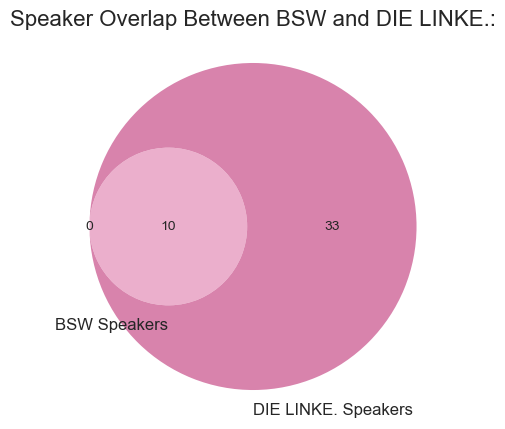

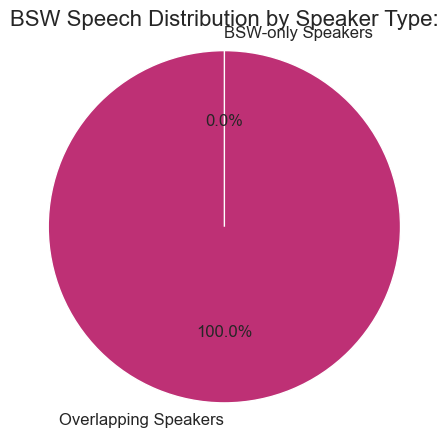

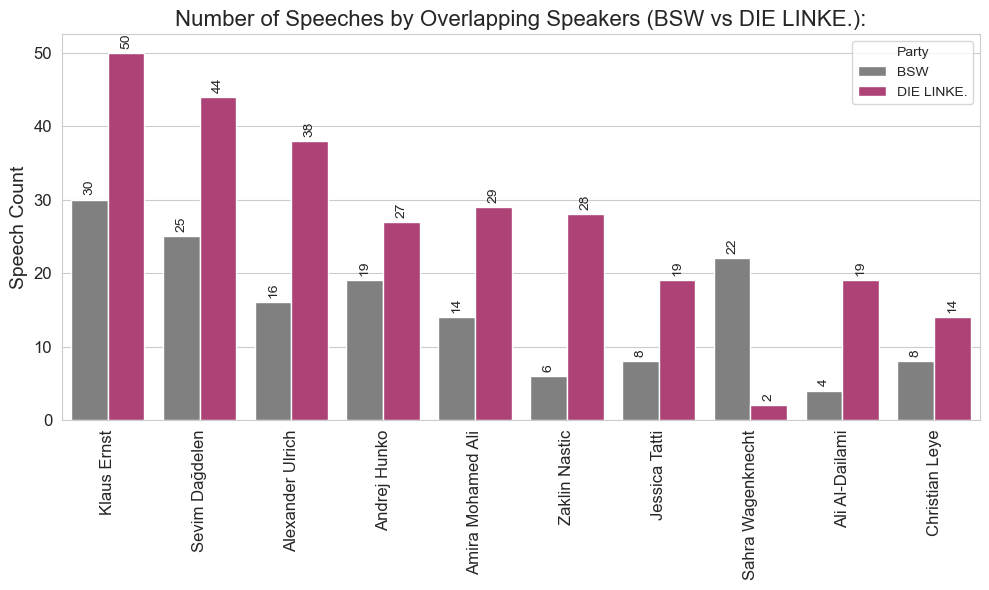

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_46592/1541207980.py:190: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_rest_sampled = (df_rest.groupby("faction_id", group_keys=False).apply(lambda x: x.sample(n=SAMPLE_SIZE, random_state=SEED)).reset_index(drop=True))



### Speech Counts per Overlapping Speaker (Markdown Table)

| full_name         |   BSW |   DIE LINKE. |
|:------------------|------:|-------------:|
| Klaus Ernst       |    30 |           50 |
| Sevim Dağdelen    |    25 |           44 |
| Alexander Ulrich  |    16 |           38 |
| Andrej Hunko      |    19 |           27 |
| Amira Mohamed Ali |    14 |           29 |
| Zaklin Nastic     |     6 |           28 |
| Jessica Tatti     |     8 |           19 |
| Sahra Wagenknecht |    22 |            2 |
| Ali Al-Dailami    |     4 |           19 |
| Christian Leye    |     8 |           14 |


Map:   0%|          | 0/1731 [00:00<?, ? examples/s]

Map:   0%|          | 0/13851 [00:00<?, ? examples/s]

Map:   0%|          | 0/1732 [00:00<?, ? examples/s]

The following layers were not sharded: bert.pooler.dense.bias, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.attention.output.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.pooler.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.embeddings.word_embeddings.weight, bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.output.LayerNorm.weight, bert.encoder.layer.*.output.dense.bias, classifier.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.atten

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,1.359800,1.291037,0.480069,0.411670
2,1.081100,1.199673,0.527441,0.469923
3,0.901200,1.238428,0.548816,0.495402
4,0.676500,1.263976,0.570191,0.507078
5,0.505600,1.324544,0.557481,0.483589


/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not suppo


Classification Report (BERT):
                       precision    recall  f1-score   support

                  AfD      0.808     0.700     0.750       300
                  BSW      0.167     0.067     0.095        15
Bündnis 90/Die Grünen      0.545     0.460     0.499       300
              CDU/CSU      0.548     0.630     0.586       300
           DIE LINKE.      0.579     0.696     0.632       217
                  FDP      0.509     0.560     0.533       300
                  SPD      0.534     0.493     0.513       300

             accuracy                          0.580      1732
            macro avg      0.527     0.515     0.516      1732
         weighted avg      0.584     0.580     0.579      1732



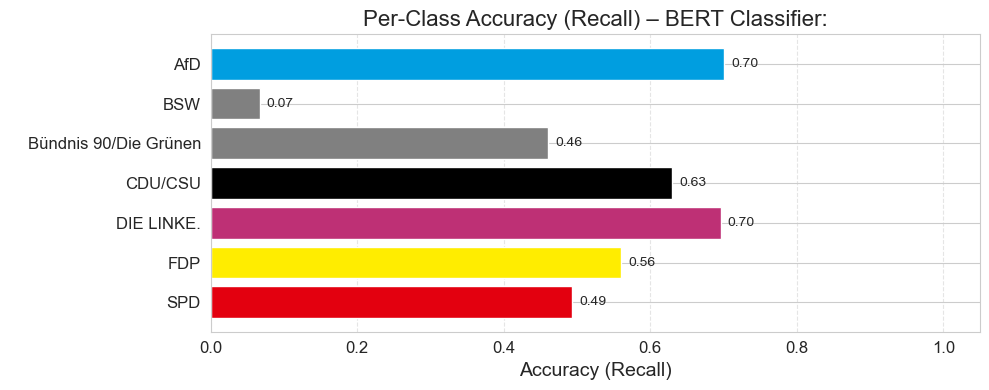

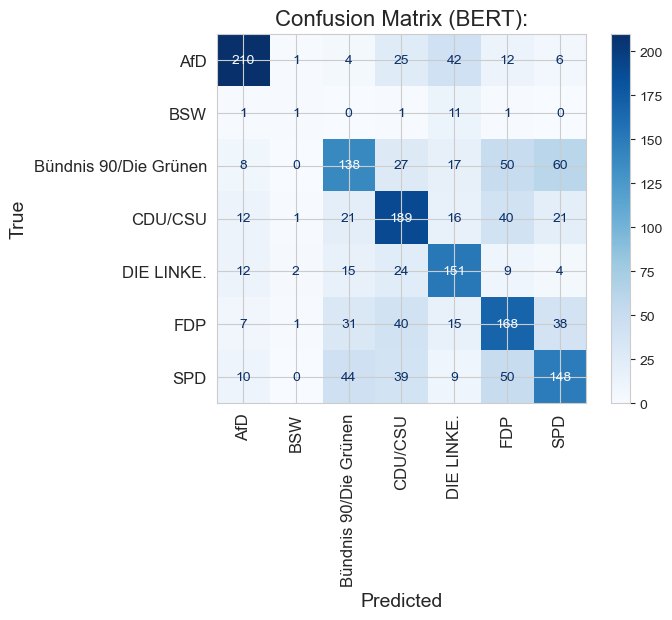

<Figure size 800x600 with 0 Axes>


[BSW] Correct predictions (BERT): 1/15
[BSW] Misclassifications with other parties (BERT):
→ AfD: 1 times (6.7%)
→ CDU/CSU: 1 times (6.7%)
→ DIE LINKE.: 11 times (73.3%)
→ FDP: 1 times (6.7%)


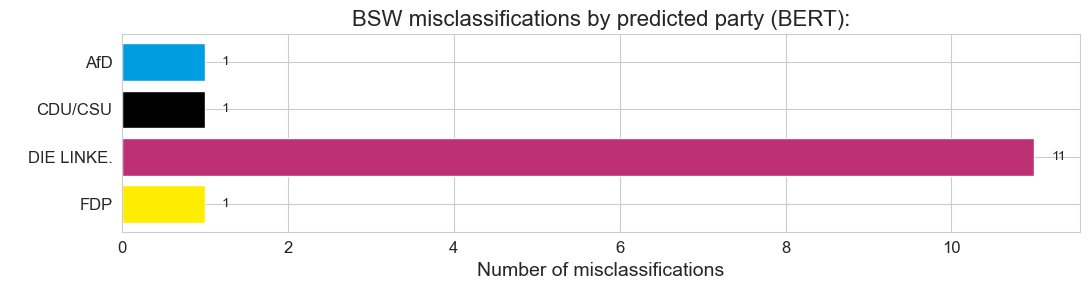


[Mutual Confusion (BERT): BSW ↔ DIE LINKE]
BSW was classified 15 times.
→ misclassified as DIE LINKE: 11 (73.33%)
DIE LINKE was classified 217 times.
→ misclassified as BSW: 2 (0.92%)


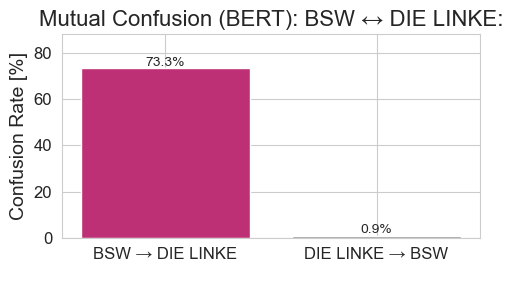

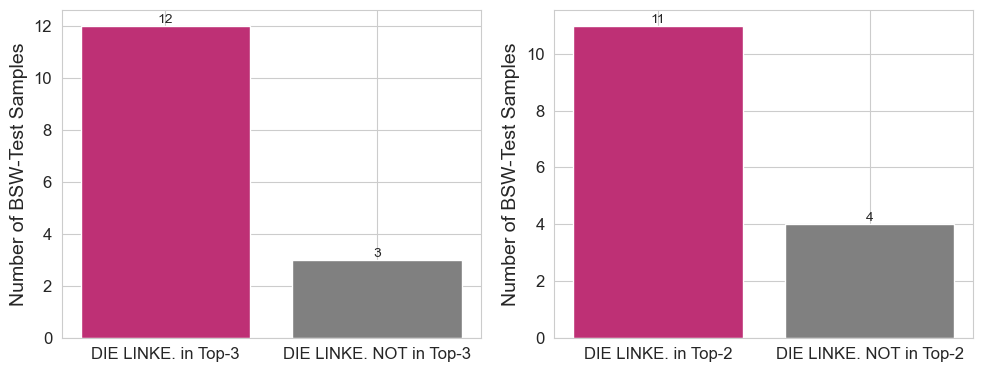

/var/folders/sk/xzcrplr925n07p_wdvs03n3w0000gn/T/ipykernel_46592/1541207980.py:528: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_other_sampled = df_other_viz.groupby("faction_id", group_keys=False).apply(


Map:   0%|          | 0/1064 [00:00<?, ? examples/s]

/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/Caskroom/miniconda/base/envs/nlp_project_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Classification Report (SVM):
                       precision    recall  f1-score   support

                  AfD      0.723     0.772     0.747       600
                  BSW      0.750     0.200     0.316        30
Bündnis 90/Die Grünen      0.581     0.553     0.567       600
              CDU/CSU      0.621     0.638     0.629       600
           DIE LINKE.      0.736     0.684     0.709       433
                  FDP      0.591     0.595     0.593       600
                  SPD      0.527     0.545     0.536       600

             accuracy                          0.625      3463
            macro avg      0.647     0.570     0.585      3463
         weighted avg      0.626     0.625     0.624      3463



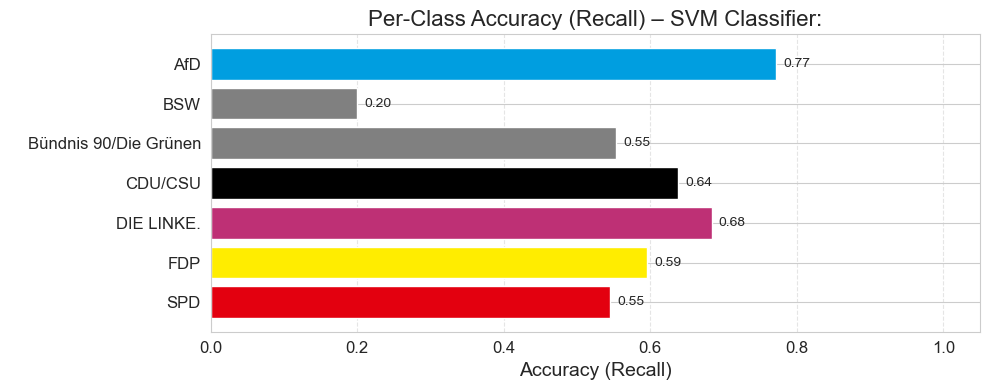

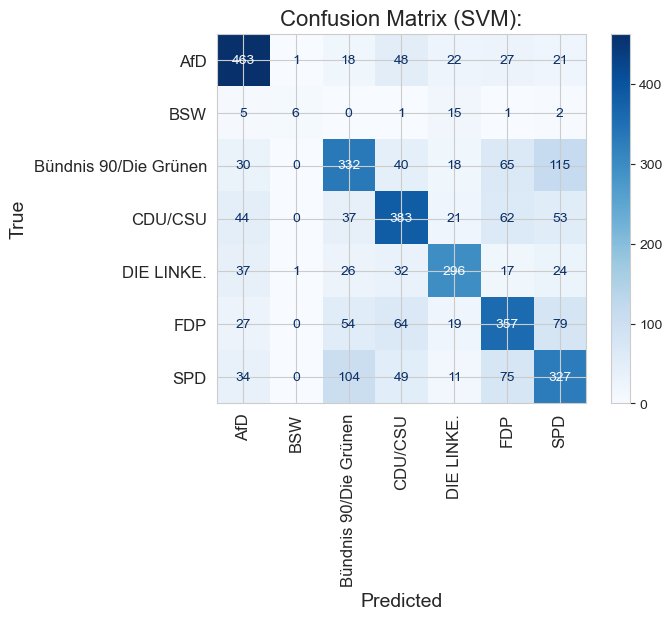

<Figure size 800x600 with 0 Axes>


[BSW] Correct predictions (SVM): 6/30
[BSW] Misclassifications with other parties (SVM):
→ AfD: 5 times (16.7%)
→ CDU/CSU: 1 times (3.3%)
→ DIE LINKE.: 15 times (50.0%)
→ FDP: 1 times (3.3%)
→ SPD: 2 times (6.7%)


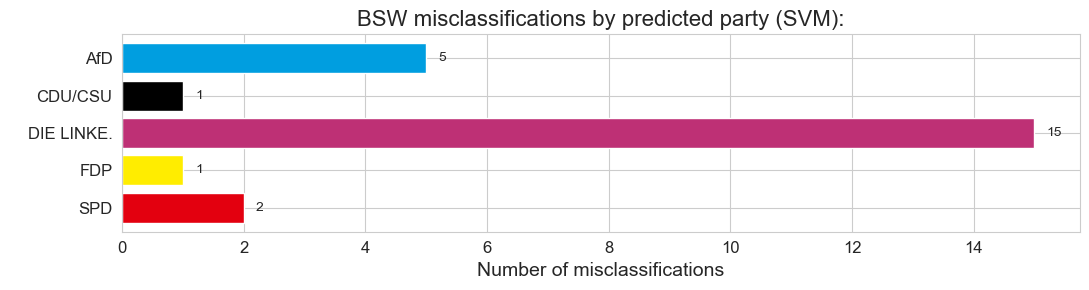


[Mutual Confusion (SVM): BSW ↔ DIE LINKE.]
BSW was classified 30 times.
→ misclassified as DIE LINKE.: 15 (50.00%)
DIE LINKE. was classified 433 times.
→ misclassified as BSW: 1 (0.23%)


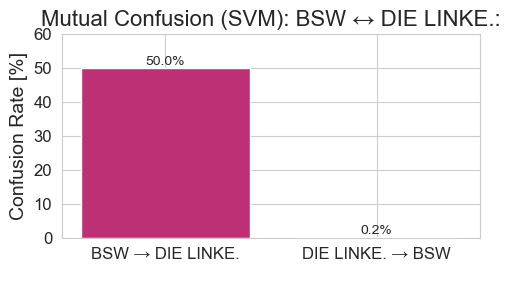


Top 25 features for BSW (SVM):
bsw, bündnis sahra wagenknecht, bündnis sahra, sahra wagenknecht, sahra, wagenknecht, bündnis, waffen, präsidentin meine, frau präsidentin meine, frau präsidentin kolleginnen, präsidentin kolleginnen, präsidentin kolleginnen und, inzwischen, mit deutschen, präsidentin meine damen, taurus, territoriale, kriegspartei, verbrenner, waffenstillstand, goldene, auftritt, etwa, wähler

Top 25 features for DIE LINKE. (SVM):
linke, als linke, die linke, wir als linke, aufrüstung, endlich, linksfraktion, konzerne, soziale, absurd, gegen, rechten, geehrte präsidentin liebe, wir linken, wenigstens, schuss, muss, arbeitsbedingungen, wirklich, sozialen, sozialwohnungen, schließlich, wie können sie, sozial, begrüßen

Shared top features between BSW and DIE LINKE. (SVM):
None


In [4]:
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
"""
Configuration: Set all model and training parameters.

:param: SEED (int): Random seed for reproducibility.
:param: BATCH_SIZE (int): Batch size for training and evaluation.
:param: EPOCHS (int): Number of training epochs.
:param: LEARNING_RATE (float): Learning rate for the AdamW optimizer.
:param: MAX_LENGTH (int): Max token length for BERT inputs.
:param: MODEL_NAME (str): Pretrained model identifier.
:param: USE_UMAP (bool): Whether to use UMAP for CLS token visualization or not.
:param: MAX_Features (int): Max number of features for SVM inputs.
:param: NGRAM_RANGE (tuple): Ngram Range for SVM Inputs.
:param: MIN_DF (int): Min DF for SVM.
:param: MAX_DF (float): Max DF for SVM.
:param: TOP_N_FEATURES  (int): Number of top TF_IDF features looked at in SVM analysis
"""
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
BATCH_SIZE = 8
EPOCHS = 5
TEST_SET_SIZE = 0.2
LEARNING_RATE = 1e-5
MAX_LENGTH = 320
SAMPLE_SIZE = 3000  # sample size for parties not BSW or DIE LINKE.
MODEL_NAME = "bert-base-german-cased"
USE_UMAP = True  # reducer for visualizing CLS Tokens
MAX_FEATURES = 50000
NGRAM_RANGE = (1, 3)
MIN_DF = 3
MAX_DF = 0.5
TOP_N_FEATURES = 25
party_colors = { # for plots
    "CDU/CSU": "#000000",
    "SPD": "#E3000F",
    "Die Grünen": "#46962B",
    "FDP": "#FFED00",
    "AfD": "#009EE0",
    "DIE LINKE.": "#BE3075",
    "BSW": "#808080"
}



def speaker_stats(df: pd.DataFrame) -> None:
    """
    Computes speaker overlap statistics between BSW and DIE LINKE. and visualizes results.

    :param df (pd.DataFrame): Input dataframe with at least 'politician_id', 'faction_id', 'first_name', 'last_name'.
    """
    # Map faction_id to abbreviation
    faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS)
    faction_map = faction_map.drop_duplicates(subset="id").set_index("id")["abbreviation"]
    df["faction_abbreviation"] = df["faction_id"].map(faction_map)

    # Filter only BSW and DIE LINKE.
    df_bsw = df[df["faction_abbreviation"] == "BSW"]
    df_linke = df[df["faction_abbreviation"] == "DIE LINKE."]

    # Sets of speakers
    speakers_bsw = set(df_bsw["politician_id"].unique())
    speakers_linke = set(df_linke["politician_id"].unique())
    overlapping_speakers = speakers_bsw & speakers_linke

    # Compute statistics
    n_bsw_speakers = len(speakers_bsw)
    n_linke_speakers = len(speakers_linke)
    n_overlap_speakers = len(overlapping_speakers)
    percent_bsw_speakers_overlapping = 100 * n_overlap_speakers / n_bsw_speakers

    df_bsw["is_overlapping_speaker"] = df_bsw["politician_id"].isin(overlapping_speakers)
    n_bsw_speeches_by_linke_speakers = df_bsw["is_overlapping_speaker"].sum()
    percent_bsw_speeches_by_linke_speakers = 100 * n_bsw_speeches_by_linke_speakers / len(df_bsw)

    print("Speaker Overlap Analysis:")
    print(f"- Number of unique BSW speakers: {n_bsw_speakers}")
    print(f"- Number of unique DIE LINKE. speakers: {n_linke_speakers}")
    print(f"- Number of overlapping speakers: {n_overlap_speakers}")
    print(f"- Percentage of BSW speakers that also spoke for DIE LINKE.: {percent_bsw_speakers_overlapping:.2f}%")
    print(f"- Share of BSW speeches by overlapping speakers: {percent_bsw_speeches_by_linke_speakers:.2f}%")

    # Speech counts per overlapping speaker
    df_overlap = df[df["politician_id"].isin(overlapping_speakers)].copy()
    df_overlap["full_name"] = df_overlap["first_name"].str.strip() + " " + df_overlap["last_name"].str.strip()

    speech_counts = df_overlap.groupby(["full_name", "faction_abbreviation"]).size().unstack(fill_value=0)
    speech_counts["Total"] = speech_counts.sum(axis=1)
    speech_counts_sorted = speech_counts.sort_values("Total", ascending=False)

    # === PLOTS ===
    # Parteifarben definieren (anpassbar!)
    party_colors = {
        "DIE LINKE.": "#BE3075",      # magenta
        "BSW": "#808080"
    }

    # Plot 1: Venn Diagram
    plt.figure(figsize=(5, 5))
    venn2([speakers_bsw, speakers_linke],
          set_labels=("BSW Speakers", "DIE LINKE. Speakers"),
          set_colors=(party_colors["BSW"], party_colors["DIE LINKE."]),
          alpha=0.6)
    plt.title("Speaker Overlap Between BSW and DIE LINKE.:", fontsize=16)
    plt.tick_params(labelsize=14)
    plt.show()

    # Plot 2: Pie Chart: BSW speech distribution
    plt.figure(figsize=(5, 5))
    labels = ["Overlapping Speakers", "BSW-only Speakers"]
    sizes = [n_bsw_speeches_by_linke_speakers, len(df_bsw) - n_bsw_speeches_by_linke_speakers]
    colors = [party_colors["DIE LINKE."], party_colors["BSW"]]
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90, textprops={'fontsize': 12}, colors=colors)
    plt.title("BSW Speech Distribution by Speaker Type:", fontsize=16)
    plt.axis("equal")
    plt.show()

    # Plot 3: Barplot: Speech counts for overlapping speakers
    melted = speech_counts_sorted.drop(columns="Total").reset_index().melt(
        id_vars="full_name", var_name="Party", value_name="Speech Count"
    )
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=melted, x="full_name", y="Speech Count", hue="Party", palette=party_colors)
    ax.set_xlabel("")  # keine x-Achsenbeschriftung
    ax.set_ylabel("Speech Count", fontsize=14)
    ax.tick_params(axis='x', labelrotation=90, labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    plt.title("Number of Speeches by Overlapping Speakers (BSW vs DIE LINKE.):", fontsize=16)
    plt.tight_layout()
    # values above bars
    for container in ax.containers:
        ax.bar_label(container, labels=[f"{int(v)}" for v in container.datavalues],
                     fontsize=10, rotation=90, padding=3)
    plt.show()

    # Plot 3 data as markdwn
    display_df = speech_counts_sorted.drop(columns="Total").astype(int)
    print("\n### Speech Counts per Overlapping Speaker (Markdown Table)\n")
    print(display_df.to_markdown())




def remove_contribution_markers(text: str) -> str:
    """
    - collapses whitespace
    - Removes content in square brackets like [Beifall], [Zwischenruf], etc.
    - Removes contribution position placeholders in the form of ({123})

    :param text (str): Raw speech text
    :return text (str): Normalized speech text
    """
    if not isinstance(text, str):
        return text  # Skip non-string entries (if any)
    text = re.sub(r'\[.*?\]', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r'\(\{\d+\}\)', ' ', text, flags=re.IGNORECASE | re.MULTILINE)
    text = re.sub(r"\s+", " ", text)
    return text.strip()



"""
Load the raw speech dataset and apply a custom sampling strategy. Also load the faction map.

:return: df_sampled (pd.DataFrame): Sampled and filtered dataset for training and evaluation.
"""
# Load faction map
faction_map = pd.read_pickle(PATHS.FINAL_FACTIONS_ABBREVIATIONS)
faction_map = faction_map.drop_duplicates(subset="id").set_index("id")["abbreviation"]

# Load and sample dataset
df = pd.read_pickle(PATHS.FINAL_SPEECH_CONTENT_20)

# Filter valid faction (without fraktionslos)
valid_ids = [0, 3, 4, 5, 7, 15, 25]
df = df[df["faction_id"].isin(valid_ids)].copy()

# Removal of Contribution Markers and collapse whitespace
df["speech_content"] = df["speech_content"].apply(remove_contribution_markers)

# overlapping speaker analysis
speaker_stats(df)

# Sampling as in strategy
def sample_strategy(df):
    df_bsw = df[df["faction_id"] == 3] # 152 speeches
    df_linke = df[df["faction_id"] == 7] # 2162 speeches
    df_rest = df[~df["faction_id"].isin([3, 7])]
    df_rest_sampled = (df_rest.groupby("faction_id", group_keys=False).apply(lambda x: x.sample(n=SAMPLE_SIZE, random_state=SEED)).reset_index(drop=True))
    return pd.concat([df_bsw, df_linke, df_rest_sampled]).sample(frac=1, random_state=SEED).reset_index(drop=True)
df_sampled = sample_strategy(df)

# encode labels (for debugging)
encoder = LabelEncoder()
df_sampled["label_encoded"] = encoder.fit_transform(df_sampled["faction_id"])



"""
Tokenize the speech text and create a HuggingFace dataset ready for training.

:return: train_test (DatasetDict): Tokenized and split dataset.
"""
# Initialize Tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
# Tokenization method
def tokenize_function(example):
    """
    Tokenizes speech content using BERT tokenizer with fixed max_length.

    :param example (dict): A dictionary containing 'speech_content'.
    :return (dict): Tokenized output with 'input_ids' and 'attention_mask'.
    """
    return tokenizer(example["speech_content"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

# Split DataFrame first via sklearn (with Stratify)
train_df, test_df = train_test_split(
    df_sampled[["speech_content", "label_encoded", "faction_id"]],
    test_size=TEST_SET_SIZE,
    stratify=df_sampled["label_encoded"],
    random_state=SEED
)
val_df,  test_df_bert = train_test_split(
    test_df,
    test_size=0.5, # half of 20 % ⇒ 10 %
    stratify=test_df["label_encoded"],
    random_state=SEED
)

# add abbreviations to test set
test_df["faction_abbreviation"] = test_df["faction_id"].map(faction_map)
# convert in HuggingFace Datasets
val_dataset   = Dataset.from_pandas(val_df.rename(columns={"label_encoded": "labels"}))
train_dataset = Dataset.from_pandas(train_df.rename(columns={"label_encoded": "labels"}))
test_dataset = Dataset.from_pandas(test_df_bert.rename(columns={"label_encoded": "labels"}))
# Tokenization
val_tokenized = val_dataset.map(tokenize_function, batched=True)
train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)
# Set format
val_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
train_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
test_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
# Pack in DatasetDict
train_test = DatasetDict({
    "train": train_tokenized,
    "val"  : val_tokenized,
    "test" : test_tokenized
})



"""
Set up the BERT classification model and training pipeline.

:return: trainer (Trainer): HuggingFace trainer object.
"""
# metric callback
def compute_metrics(pred):
    y_pred = np.argmax(pred.predictions, axis=1)
    y_true = pred.label_ids
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro")
    }

# Initialize BERT model and trainer
bert_model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=df_sampled["label_encoded"].nunique())

# Trainingsarguments
training_args = TrainingArguments(
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=0.01,
    seed=SEED,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    save_total_limit=1,
    disable_tqdm=False
)

# Data-Collator (automatic Padding)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Initialize BERT trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_test["train"],
    eval_dataset =train_test["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)


"""
Start model training with HuggingFace Trainer.
"""
trainer.train()

# Generate Predictions
predictions = trainer.predict(train_test["test"])
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids



"""
Evaluate the BERT model: Classification report. Examine and plot per-class-performace of the model
"""
# reverse encoder mapping and ID → Party Mapping
labels = encoder.inverse_transform(np.arange(len(encoder.classes_)))
label_names = [faction_map.get(fid, f"faction_{fid}") for fid in labels] # Compute abbreviations for matrix labels

# Generate classification report
report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Print text report
print("\nClassification Report (BERT):")
print(classification_report(
    y_true,
    y_pred,
    target_names=label_names,
    digits=3
))

# Plot per-class accuracy
accuracies = [report[label]["recall"] for label in label_names]

plt.figure(figsize=(10, 4))
colors = [party_colors.get(name, "gray") for name in label_names]
plt.barh(label_names, accuracies, color=colors)
plt.xlabel("Accuracy (Recall)", fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel(" ")
plt.title("Per-Class Accuracy (Recall) – BERT Classifier:", fontsize=16)
plt.xlim(0, 1.05)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
for i, (label, acc) in enumerate(zip(label_names, accuracies)):
    plt.text(acc + 0.01, i, f"{acc:.2f}", va='center', fontsize=10)
plt.show()



"""
Evaluate the BERT model and plot confusion matrix from test predictions.
"""
# Interesting to know while debugging: loss of data due to cutting at 320 tokens
#token_lens = [len(tokenizer.encode(s, truncation=False)) for s in df_sampled["speech_content"]]
#plt.hist(token_lens, bins=50)
#plt.title("Verteilung der Tokenlängen")
#plt.xlabel("Anzahl Tokens pro Rede")
#plt.ylabel("Häufigkeit")
#plt.tight_layout()
#plt.show()

# plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.title("Confusion Matrix (BERT):", fontsize=16)
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.show()

# Index mapping in confusion matrix
BSW_ID = 3
LINKE_ID = 7
bsw_idx = np.where(labels == BSW_ID)[0][0]
linke_idx = np.where(labels == LINKE_ID)[0][0]



"""
Evaluate the BERT model: Analyze how often BSW was confused for another party.
"""
# BSW Confusion Overview
bsw_row = cm[bsw_idx]                   # All predictions for true BSW
bsw_correct = bsw_row[bsw_idx]          # Correct BSW predictions
bsw_total = bsw_row.sum()               # Total BSW predictions
bsw_confusions = {
    faction_map[labels[i]]: count
    for i, count in enumerate(bsw_row) if i != bsw_idx and count > 0
}

# Text report: All BSW misclassifications
print(f"\n[BSW] Correct predictions (BERT): {bsw_correct}/{bsw_total}")
print("[BSW] Misclassifications with other parties (BERT):")
for party, count in bsw_confusions.items():
    percent = count / bsw_total * 100
    print(f"→ {party}: {count} times ({percent:.1f}%)")

# Plot: All BSW misclassifications
plt.figure(figsize=(11, 3))
colors = [party_colors.get(party, "gray") for party in bsw_confusions.keys()]
plt.barh(list(bsw_confusions.keys()), list(bsw_confusions.values()), color=colors)
plt.xlabel("Number of misclassifications", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel(" ")
plt.title("BSW misclassifications by predicted party (BERT):", fontsize=16)
plt.gca().invert_yaxis()
for i, (party, count) in enumerate(bsw_confusions.items()):
    plt.text(count + 0.2, i, str(count), va='center', fontsize=10)
plt.tight_layout()
plt.show()



"""
Evaluate the BERT model: Analyze how often BSW was confused for DIE LINKE. and vice versa.
"""
# Mutual confusion BSW ↔ DIE LINKE
bsw_as_linke = cm[bsw_idx, linke_idx]
linke_as_bsw = cm[linke_idx, bsw_idx]
linke_total = cm[linke_idx].sum()

# Text report: Mutual confusion
print("\n[Mutual Confusion (BERT): BSW ↔ DIE LINKE]")
print(f"BSW was classified {bsw_total} times.")
print(f"→ misclassified as DIE LINKE: {bsw_as_linke} ({bsw_as_linke / bsw_total:.2%})")
print(f"DIE LINKE was classified {linke_total} times.")
print(f"→ misclassified as BSW: {linke_as_bsw} ({linke_as_bsw / linke_total:.2%})")

# Plot: Mutual confusion
plt.figure(figsize=(5, 3))
plt.bar(
    ['BSW → DIE LINKE', 'DIE LINKE → BSW'],
    [bsw_as_linke / bsw_total * 100, linke_as_bsw / linke_total * 100],
    color=[party_colors["DIE LINKE."], party_colors["BSW"]]
)
plt.ylabel("Confusion Rate [%]", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel(" ")
plt.title("Mutual Confusion (BERT): BSW ↔ DIE LINKE:", fontsize=16)
plt.ylim(0, max(bsw_as_linke / bsw_total, linke_as_bsw / linke_total) * 120)  # headroom
values = [bsw_as_linke / bsw_total * 100, linke_as_bsw / linke_total * 100]
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=10)
plt.tight_layout()
plt.show()



"""
Evaluate the BERT model: Top-k Predictions: (in one plot)
- Plot the number of BSW-test-instances where DIE LINKE. is among the top-3 predicted classes against the
number of instances where DIE LINKE. is not among the top-3 predicted classes.
- Plot the number of BSW-test-instances where DIE LINKE. is among the top-2 predicted classes against the
number of instances where DIE LINKE. is not among the top-2 predicted classes.
"""
# Get test indices of BSW
bsw_test_indices = np.where(y_true == encoder.transform([BSW_ID])[0])[0]

# Get top-k predictions
probs = predictions.predictions[bsw_test_indices]
top3 = np.argsort(probs, axis=1)[:, -3:][:, ::-1]
top2 = top3[:, :2]  # top-2 = subset of top-3

# Get encoded label for DIE LINKE.
linke_encoded = encoder.transform([7])[0]

# Count how often DIE LINKE is in top-2/top-3 predictions
in_top3 = np.any(top3 == linke_encoded, axis=1)
in_top2 = np.any(top2 == linke_encoded, axis=1)

# Count occurrences
count_top3 = np.sum(in_top3)
count_not_top3 = len(in_top3) - count_top3
count_top2 = np.sum(in_top2)
count_not_top2 = len(in_top2) - count_top2

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].bar(["DIE LINKE. in Top-3", "DIE LINKE. NOT in Top-3"], [count_top3, count_not_top3],
           color=[party_colors["DIE LINKE."], "gray"])
axs[1].bar(["DIE LINKE. in Top-2", "DIE LINKE. NOT in Top-2"], [count_top2, count_not_top2],
           color=[party_colors["DIE LINKE."], "gray"])

# Title and Labels
for ax in axs:
    ax.set_title(ax.get_title(), fontsize=16)
    ax.set_ylabel("Number of BSW-Test Samples", fontsize=14)
    ax.set_xlabel(" ")
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

# bar writing
for ax in axs:
    for container in ax.containers:
        ax.bar_label(container, fontsize=10)

plt.tight_layout()
plt.show()




"""
Project the [CLS] token embeddings to 2D using UMAP or t-SNE and visualizes them by party.
"""
# === Custom Sampling for CLS Visualization ===
df_viz = df_sampled.copy()
df_viz["label_encoded"] = encoder.transform(df_viz["faction_id"])

# Separate BSW and non-BSW
df_bsw_viz = df_viz[df_viz["faction_id"] == 3]
df_other_viz = df_viz[df_viz["faction_id"] != 3]

# Sample 152 from each other party
df_other_sampled = df_other_viz.groupby("faction_id", group_keys=False).apply(
    lambda x: x.sample(n=152, random_state=SEED)
).reset_index(drop=True)

# Combine all 152 BSW + 152 from each other party
df_viz_balanced = pd.concat([df_bsw_viz, df_other_sampled]).reset_index(drop=True)

# Encode labels
df_viz_balanced["label_encoded"] = encoder.transform(df_viz_balanced["faction_id"])

# Create HuggingFace Dataset and tokenize
viz_dataset = Dataset.from_pandas(df_viz_balanced[["speech_content", "label_encoded"]].rename(columns={"label_encoded": "labels"}))
viz_tokenized = viz_dataset.map(tokenize_function, batched=True)
viz_tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# Create DataLoader
viz_dataloader = DataLoader(viz_tokenized, batch_size=BATCH_SIZE, collate_fn=data_collator)

# === Extract CLS Embeddings from balanced sample
all_embeddings, all_labels = [], []

with torch.no_grad():
    for batch in viz_dataloader:
        input_ids      = batch["input_ids"].to(bert_model.device)
        attention_mask = batch["attention_mask"].to(bert_model.device)
        labels         = batch["labels"]

        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True,
            return_dict=True
        )
        cls_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()

        all_embeddings.append(cls_embeddings)
        all_labels.append(labels.cpu().numpy())

X_embed = np.vstack(all_embeddings)
y_embed = np.concatenate(all_labels)

# Abkürzungen mappen für Plot
faction_ids_embed = encoder.inverse_transform(y_embed)
color_labels = [faction_map.get(fid, f"faction_{fid}") for fid in faction_ids_embed]

# chooseUMAP or t-SNE
if USE_UMAP:
    reducer = umap.UMAP(random_state=SEED, n_neighbors=15, min_dist=0.1)
    X_proj = reducer.fit_transform(X_embed, y_embed) # Supervised UMAP using class labels
    method = "UMAP"
else:
    reducer = TSNE(n_components=2, random_state=SEED, perplexity=30)
    X_proj = reducer.fit_transform(X_embed)
    method = "t-SNE"

# Plot
fig = px.scatter(
    x=X_proj[:, 0],
    y=X_proj[:, 1],
    color=color_labels,
    labels={"color": "Partei"},
    title = f"{'Supervised' if USE_UMAP else 'Unsupervised'} {method} Projection of [CLS] Embeddings:",
    opacity=0.6,
    color_discrete_map=party_colors
)
fig.show()



"""
Bulid dataset for TF-IDF vectorization and SVM model
"""
def lower_case(text: str) -> str:
    """
    Normalizes text to lowercase and collapses whitespace for TF-IDF vectorization

    :param text (str): Raw speech text
    :return text (str): Normalized speech text
    """
    if not isinstance(text, str):
        return text  # Skip non-string entries (if any)
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

# normalize dataset to lowercase for less sparse TF-IDF vectors
train_df["speech_content"] = train_df["speech_content"].apply(lower_case)
test_df["speech_content"] = test_df["speech_content"].apply(lower_case)

# Input: extract features and targets (same split as BERT at the top)
X_train = train_df["speech_content"]
X_test = test_df["speech_content"]
y_train = train_df["faction_id"]
y_test = test_df["faction_id"]



"""
Define TF-IDF & SVM pipeline and train the classifier
"""
clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=MAX_FEATURES, ngram_range=NGRAM_RANGE, min_df=MIN_DF, max_df=MAX_DF)),
    ("clf", LinearSVC(random_state=SEED))
])
# Train
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_true = test_df["faction_id"].values



"""
Evaluate the SVM model: Classification report. Examine and plot per-class-performace of the model
"""
# reverse encoder mapping and ID → Party Mapping
labels = encoder.inverse_transform(np.arange(len(encoder.classes_)))
label_names = [faction_map.get(fid, f"faction_{fid}") for fid in labels] # Compute abbreviations for matrix labels

# Generate classification report
report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True)

# Print text report
print("\nClassification Report (SVM):")
print(classification_report(
    y_true,
    y_pred,
    target_names=label_names,
    digits=3
))

# Plot per-class accuracy
accuracies = [report[label]["recall"] for label in label_names]
colors = [party_colors.get(name, "gray") for name in label_names]
plt.figure(figsize=(10, 4))
bars = plt.barh(label_names, accuracies, color=colors)
plt.xlabel("Accuracy (Recall)", fontsize=14)
plt.ylabel(" ")
plt.title("Per-Class Accuracy (Recall) – SVM Classifier:", fontsize=16)
plt.xlim(0, 1.05)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.gca().invert_yaxis()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for bar in bars:
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height() / 2,
             f"{bar.get_width():.2f}", va='center', fontsize=10)
plt.tight_layout()
plt.show()



"""
Evaluate the SVM model: Confusion Matrix as DataFrame
"""
# plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.title("Confusion Matrix (SVM):", fontsize=16)
plt.figure(figsize=(8, 6))
plt.tight_layout()
plt.show()

# Index mapping in confusion matrix
BSW_ID = 3
LINKE_ID = 7
bsw_idx = np.where(labels == BSW_ID)[0][0]
linke_idx = np.where(labels == LINKE_ID)[0][0]



"""
Analyse SVM model: BSW misclassifications
"""
# BSW Confusion Overview
bsw_row = cm[bsw_idx]                   # All predictions for true BSW
bsw_correct = bsw_row[bsw_idx]          # Correct BSW predictions
bsw_total = bsw_row.sum()               # Total BSW predictions
bsw_confusions = {
    faction_map[labels[i]]: count
    for i, count in enumerate(bsw_row) if i != bsw_idx and count > 0
}

# Text report: All BSW misclassifications
print(f"\n[BSW] Correct predictions (SVM): {bsw_correct}/{bsw_total}")
print("[BSW] Misclassifications with other parties (SVM):")
for party, count in bsw_confusions.items():
    percent = count / bsw_total * 100
    print(f"→ {party}: {count} times ({percent:.1f}%)")

# Plot: Misclassifications of BSW
colors = [party_colors.get(p, "gray") for p in bsw_confusions.keys()]
plt.figure(figsize=(11, 3))
bars = plt.barh(list(bsw_confusions.keys()), list(bsw_confusions.values()), color=colors)
plt.xlabel("Number of misclassifications", fontsize=14)
plt.ylabel(" ")
plt.title("BSW misclassifications by predicted party (SVM):", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for bar in bars:
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height() / 2,
             str(int(bar.get_width())), va='center', fontsize=10)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



"""
Analyse SVM model: Mutual confusion between BSW and DIE LINKE.
"""
# Mutual confusion BSW ↔ DIE LINKE.
bsw_as_linke = cm[bsw_idx, linke_idx]
linke_as_bsw = cm[linke_idx, bsw_idx]
linke_total = cm[linke_idx].sum()

# Text report: Mutual confusion
print("\n[Mutual Confusion (SVM): BSW ↔ DIE LINKE.]")
print(f"BSW was classified {bsw_total} times.")
print(f"→ misclassified as DIE LINKE.: {bsw_as_linke} ({bsw_as_linke / bsw_total:.2%})")
print(f"DIE LINKE. was classified {linke_total} times.")
print(f"→ misclassified as BSW: {linke_as_bsw} ({linke_as_bsw / linke_total:.2%})")

# Plot: Mutual confusion
colors = [party_colors["DIE LINKE."], party_colors["BSW"]]
values = [bsw_as_linke / bsw_total * 100, linke_as_bsw / linke_total * 100]
plt.figure(figsize=(5, 3))
bars = plt.bar(['BSW → DIE LINKE.', 'DIE LINKE. → BSW'], values, color=colors)
plt.ylabel("Confusion Rate [%]", fontsize=14)
plt.xlabel(" ")
plt.title("Mutual Confusion (SVM): BSW ↔ DIE LINKE.:", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             f"{bar.get_height():.1f}%", ha='center', fontsize=10)
plt.ylim(0, max(values) * 1.2)
plt.tight_layout()
plt.show()



"""
Anayse SVM Model: Top TF-IDF Feature analysis
"""
def show_top_features_for_classes(vectorizer, classifier, class_ids, class_labels, top_n=15):
    """
    Display top TF-IDF features with highest SVM weights per class.

    :param vectorizer: Fitted TfidfVectorizer
    :param classifier: Trained LinearSVC classifier
    :param class_ids: List of integer class IDs to compare (e.g. [3, 7])
    :param class_labels: Mapping of class IDs to readable labels
    :param top_n: Number of top features to show
    """
    feature_names = np.array(vectorizer.get_feature_names_out())
    class_indices = [list(classifier.classes_).index(c) for c in class_ids]
    coefs = classifier.coef_

    top_features = {}

    for idx, class_id in zip(class_indices, class_ids):
        # Get top n features for class
        topn = np.argsort(coefs[idx])[-top_n:]
        features = feature_names[topn][::-1]
        top_features[class_id] = features

        print(f"\nTop {top_n} features for {class_labels[class_id]} (SVM):")
        print(", ".join(features))

    # Optional: Find overlap between feature sets
    overlap = set(top_features[class_ids[0]]) & set(top_features[class_ids[1]])
    print(f"\nShared top features between {class_labels[class_ids[0]]} and {class_labels[class_ids[1]]} (SVM):")
    if overlap:
        print(", ".join(sorted(overlap)))
    else:
        print("None")

# Run Top-TF-IDF analysis
show_top_features_for_classes(
    vectorizer=clf.named_steps["tfidf"],
    classifier=clf.named_steps["clf"],
    class_ids=[3, 7],  # BSW and DIE LINKE.
    class_labels=faction_map,
    top_n=TOP_N_FEATURES)

# **Evaluation: Should `BSW` be Merged into `DIE LINKE.`?**


## **1. Speaker Overlap Analysis: A Strong Case for Rhetorical Continuity**

- **The speaker overlap between `BSW` and `DIE LINKE.` is total:**
    - All 10 `BSW` speakers previously spoke for `DIE LINKE.`, so all 152 `BSW` speeches in the dataset were held by such individuals.
    - The top `BSW` speakers (e.g., Klaus Ernst, Sevim Dağdelen) had long careers within `DIE LINKE.` and contributed substantial numbers of speeches to both parties.
- Since all `BSW` speeches come from former `DIE LINKE.` members, their linguistic signatures are very likely to mirror their prior `DIE LINKE.` contributions. And if we further consider that **speaker identity is a strong proxy for party affiliation**, this speaker overlap analysis provides empirical support for the hypothesis that `BSW's` rhetorical identity — at least in this dataset — is unlikely to be institutionally distinct, but rather a continuation of `DIE LINKE.’s` communicative style.

> The dataset does not reflect a unique rhetorical speaker pool for `BSW`, but a repackaging of former `DIE LINKE.` voices. Such complete overlap indicates that `BSW` is unlikely to be distinguishable from `DIE LINKE.` on a linguistic level, which strengthens the argument for merging.


---


## **2. Confusion Matrix Analysis: Semantic Indistinguishability in Action**

**BERT Results (Contextual Model):**
- 1 of 30 `BSW` speeches were correctly classified while 11 (73.3 %) were misclassified as `DIE LINKE.`.
- Notably, no `DIE LINKE.` speech was ever misclassified as `BSW`.
- For nearly all `BSW` speeches, `DIE LINKE.`. appeared consistently among the Top-1 or Top-2 prediction

**SVM Results (Lexical Model):**
- 6 of 30 `BSW` speeches were correctly classified (20 % recall).
- 15 of 30 (50 %) `BSW` speeches were misclassified as `DIE LINKE.`.
- 1 of 433 `DIE LINKE.` speeches was misclassified as `BSW` (0.23 %).

### **Key Observations:**
Across both models **`BSW` → `DIE LINKE.` confusion** constitutes one of the strongest and most asymmetrical pairwise misclassification patterns observed. This pronounced pattern of one-directional confusion suggests that `BSW’s` linguistic footprint is not distinguishable enough from `DIE LINKE.’s` and therefore provides a solid rationale for our hypothesis of semantic proximity between these two parties.

### **The Significance of Asymmetric Misclassification: One-Way Confusion:**
- The observed confusion is notably asymmetric: While `BSW` is frequently misclassified as `DIE LINKE.`, the reverse virtually never occurs (as can be seen in the `mutual confusion` plots ).
- Even though partially expected given the extreme class imbalance, the pronounced asymmetry remains remarkably significant.
- This indicates that `BSW` speeches linguistically constitute a subset of the broader vocabulary and speaker diversity observed in `DIE LINKE.`, suggesting a narrower lexical and contextual range.

### **Model-Specific Analysis: Sensitivity to Class Imbalance:**
- The distinction between the observed confusion patterns of BERT and SVM models highlights their differing sensitivities to class imbalance:
    - **BERT (contextual):** Due to its stochastic gradient-based training and contextual embeddings, BERT inherently suffers more from severe class imbalances. Consequently, it exhibits a very high misclassification rate (73.3 %) of `BSW` speeches as `DIE LINKE.`.
    - **SVM (lexical):** In contrast, the Support Vector Machine, which uses a lexically-based TF-IDF feature space and optimizes global margins, theoretically exhibits greater inherit robustness against class imbalance as long as the classes are linearly separable in the feature space. This robustness is reflected in the significantly lower misclassification rate of 50 %.
- That said, despite its theoretical advantage and structural resilience, even the SVM model struggles to draw a clear lexical boundary between `BSW` and `DIE LINKE.`. The persistence of substantial confusion (50 %) underlines a fundamental indistinguishability in the lexical domain as well.

> From a classification perspective, the results strongly indicate that the `BSW` speeches lack a distinct linguistic identity — both contextually and lexically — and consistently overlap with the discourse style of `DIE LINKE.`. Consequently, both models effectively **treat `BSW` as a subset of `DIE LINKE.`**, providing strong empirical support for merging these classes in subsequent classification and analytical tasks.


---


## **3. Classification Report: Poor Separability and Class Performance**

**BERT (Contextual Model):**
- Complete failure to classify `BSW` correctly: Precision, Recall, F1 all at 0.0 for `BSW`.
- Overall lower performance (Macro F1 = 0.516), significantly influenced by the small and indistinguishable `BSW` class.

**SVM (Lexical Model):**
- Higher Precision for `BSW` (0.750) is misleading due to the low true positive rate (Recall of 0.200).
- Overall better Macro F1 (0.585), indicating better robustness despite still low separability for `BSW`.

> The consistently low performance metrics for BSW underline the "confusable class" hypothesis that the class is indistinguishable linguistically from DIE LINKE. and is not learnable as a separate entity. The prediction quality deteriorates as a result.


---


## **4. Top-K Predictions (BERT)**

In 11 out of 15 `BSW` samples, `DIE LINKE.`. was predicted as the Top-1 class. In an additional sample, `DIE LINKE.`. was among the Top-3 predictions. So the model consistently “considers” `DIE LINKE.`. a close alternative for `BSW` samples.

> This consistently high uncertainty, coupled with systematic preference towards `DIE LINKE.`, emphasizes the semantic embedding of `BSW` within `DIE LINKE.’s` domain.


---


## **5. UMAP Embedding Visualization**

- The UMAP visualization does not clearly support the semantic proximity hypothesis due to methodological limitations.
- Unsupervised embeddings were uninterpretable, and supervised embeddings potentially distorted class relationships, rendering the visual evidence inconclusive.


---


## **TF-IDF Feature Analysis (SVM)**

- **Top 25 Features for `BSW`:** Highly personalized terms ("Sahra Wagenknecht", "frau präsidentin meine damen") alongside specific political terms ("taurus", "waffenstillstand").

- ***Top 25 Features for `DIE LINKE.`:** Broadly collective and programmatic vocabulary ("als linke", "soziale", "linksfraktion", "aufrüstung").



---


# **Final Interpretation and Conclusion**

**The evaluations confirm significant linguistic overlap and structural indistinguishability between `BSW` and `DIE LINKE.` within the dataset:**
- Both the lexical model (SVM) and the contextual model (BERT) consistently fail to clearly separate `BSW` from `DIE LINKE.`.
- Misclassifications are highly asymmetric: `BSW` is frequently predicted as `DIE LINKE.`, but the reverse misclassification is virtually nonexistent.
- The speaker base of `BSW` entirely overlaps with that of `DIE LINKE.`, reflecting their historical ties and organizational similarities.
- There is no "pure BSW" linguistic identity present in the data, only a repackaging of `DIE LINKE.`. rhetoric under a new label — which classification models cannot reasonably be expected to separate.

**Merging `BSW` into `DIE LINKE.` offers several benefits:**
- Improved class balance, enabling more robust training.
- Enhanced interpretability and robustness of evaluation metrics.
- Reduced semantic noise in the label space, clarifying downstream analyses.

> Merging `BSW` into `DIE LINKE.` to improve model interpretability, metric validity and training stability is fully justified for this classification task.
> Given our observations, merging reduces artificial class fragmentation, improves label balance, and aligns with both political context and the dataset's observed linguistic reality.


---


Back to [`ML-Task-1: Classification`](ML-Task-1_Classification.ipynb).

Back to [`ML-Task-1: Speech Length Experiment`](ML-Task-1_Speech-Length-Experiment.ipynb).
